In [1]:
using Random
using Statistics

using BenchmarkTools
using ProgressMeter

using Plots
pyplot()

using InteractiveUtils

using Revise
using SimpleClifford
versioninfo()

Julia Version 1.2.0-rc1.0
Commit 7097799cf1 (2019-05-30 02:22 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i5-3210M CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, ivybridge)


In [2]:
function plotres(pows,res,title)
    ns = 2 .^ pows
    p = plot(ns, [median(r.times) for r in res]./1e9,
        yaxis=:log, xaxis=:log,
        title=title,
        xlabel="Number of qubits",
        ylabel="Execution time (seconds)",
        label="median")
    plot!(p, ns, [minimum(r.times) for r in res]./1e9, label="minimum")
    plot!(p, ns, [maximum(r.times) for r in res]./1e9, label="maximum (due to GC delays)")
    meds = [median(b.times) for b in res[end÷2:end]]./1e9
    y = log10.(meds)
    x = log10(2)*pows[end÷2:end]
    x = hcat(x,ones(size(x)))
    slope = (x\y)[1]
    plot!(p, ns, meds[end]*(ns / ns[end]).^slope,
        label="O(n^$(round(slope,sigdigits=2)))",
        linestyle=:dash,linecolor=:black)
    p
end

plotres (generic function with 1 method)

# Canonicalization

In [3]:
pows = [3,4,5,6,7,8,9,10]
res = []
for p in pows
    @show n=2^p
    stab = random_stabilizer(n)
    b = @benchmark canonicalize!(s) setup=(s = copy($stab))
    push!(res,b)
end

n = 2 ^ p = 8
n = 2 ^ p = 16
n = 2 ^ p = 32
n = 2 ^ p = 64
n = 2 ^ p = 128
n = 2 ^ p = 256
n = 2 ^ p = 512
n = 2 ^ p = 1024


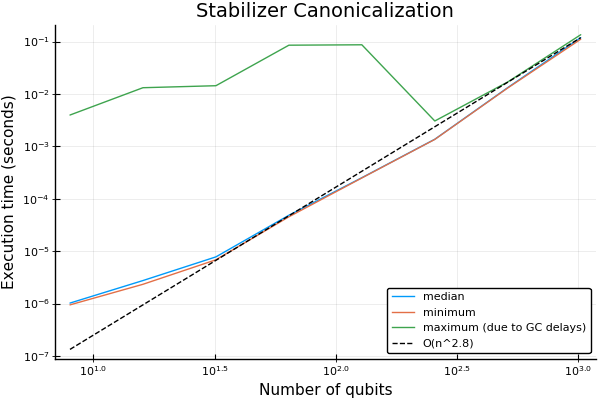

In [4]:
plotres(pows,res,"Stabilizer Canonicalization")

# Projective measurements

In [5]:
pows = [5,6,7,8,10]
res = []
for p in pows
    @show n=2^p
    state = random_stabilizer(n)
    meas = single_z(n,1)
    b = @benchmark project!(s, m) setup=((s,m)=(copy($state),copy($meas)))
    push!(res,b)
end

n = 2 ^ p = 32
n = 2 ^ p = 64
n = 2 ^ p = 128
n = 2 ^ p = 256
n = 2 ^ p = 1024


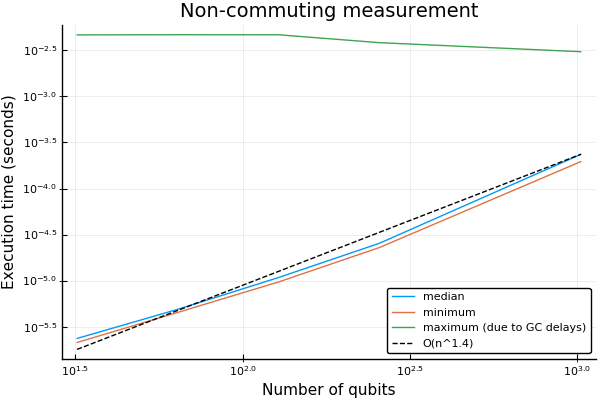

In [6]:
plotres(pows,res,"Non-commuting measurement")

In [7]:
pows = [5,6,7,8,10]
res = []
for p in pows
    @show n=2^p
    state = calculate_destabilizer(random_stabilizer(n))
    meas = single_z(n,1)
    b = @benchmark project!(s, m) setup=((s,m)=(copy($state),copy($meas)))
    push!(res,b)
end

n = 2 ^ p = 32
n = 2 ^ p = 64
n = 2 ^ p = 128
n = 2 ^ p = 256
n = 2 ^ p = 1024


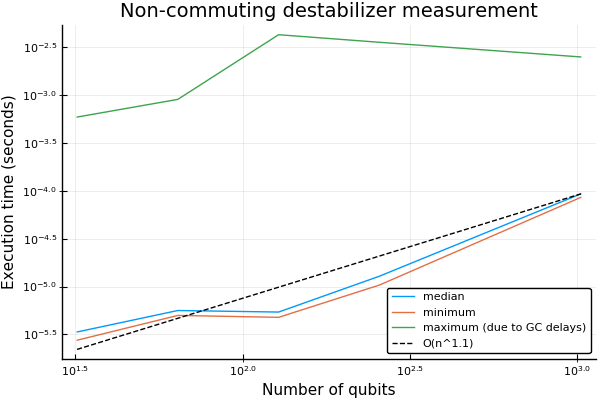

In [8]:
plotres(pows,res,"Non-commuting destabilizer measurement")

In [9]:
pows = [5,6,7,8,10]
res = []
for p in pows
    @show n=2^p
    state = random_stabilizer(n)
    meas = state[1]
    for i in 2:5:n
        meas = meas*state[i]
    end
    b = @benchmark project!(s, m) setup=((s,m)=(copy($state),copy($meas)))
    push!(res,b)
end

n = 2 ^ p = 32
n = 2 ^ p = 64
n = 2 ^ p = 128
n = 2 ^ p = 256
n = 2 ^ p = 1024


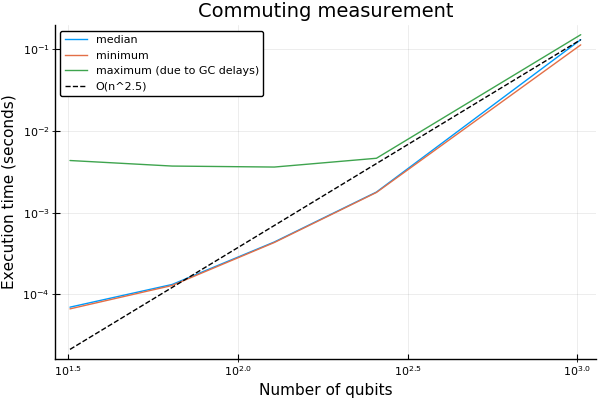

In [10]:
plotres(pows,res,"Commuting measurement")

In [11]:
pows = [5,6,7,8,10]
res = []
for p in pows
    @show n=2^p
    state = calculate_destabilizer(random_stabilizer(n))
    stab = state.stabilizer
    meas = stab[1]
    for i in 2:5:n
        meas = meas*stab[i]
    end
    b = @benchmark project!(s, m) setup=((s,m)=(copy($state),copy($meas)))
    push!(res,b)
end

n = 2 ^ p = 32
n = 2 ^ p = 64
n = 2 ^ p = 128
n = 2 ^ p = 256
n = 2 ^ p = 1024


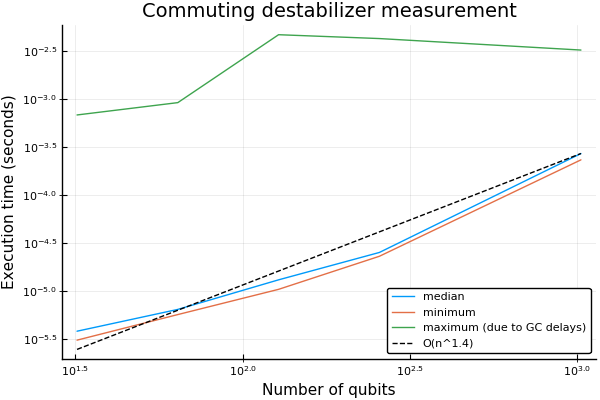

In [12]:
plotres(pows,res,"Commuting destabilizer measurement")

# Syndrome measurements for $k=\frac{n}{2}$ random codes with $\frac{n-k}{4}$ erasures

In [13]:
function setup(n)
    k = n÷2
    stab = random_stabilizer(n)
    indices = randperm(n)[1:(n-k)]
    code = copy(stab[indices]) # TODO this should automatically be a copy
    state = copy(code)
    errased = (n-k)÷4
    bad_indices = randperm(n-k)[1:errased]
    for i in bad_indices
        project!(state,single_z(n,i), keep_result=false)
    end
    code, state
end

setup (generic function with 1 method)

In [14]:
function measure(code, state)
    nothings = 0
    for i in 1:lastindex(code) # TODO bad notation
        nothings += isnothing(project!(state, code[i])[end])
    end
    state, nothings
end

measure (generic function with 1 method)

In [15]:
pows = [3,4,5,6,7,8,9,10]
res = []
for p in pows
    @show n=2^p
    code, state = setup(n)
    b = @benchmark measure(c, s) setup=((c,s) = (copy($code),copy($state)))
    push!(res,b)
end

n = 2 ^ p = 8
n = 2 ^ p = 16
n = 2 ^ p = 32
n = 2 ^ p = 64
n = 2 ^ p = 128
n = 2 ^ p = 256
n = 2 ^ p = 512
n = 2 ^ p = 1024


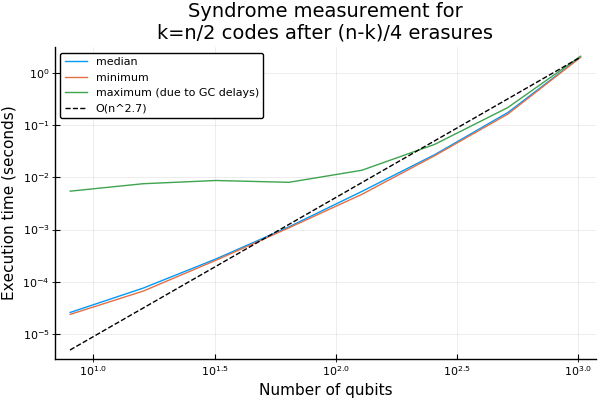

In [16]:
plotres(pows,res,"Syndrome measurement for\nk=n/2 codes after (n-k)/4 erasures")

In [17]:
pows = [3,4,5,6,7,8,9,10]
res = []
for p in pows
    @show n=2^p
    code, state = setup(n)
    state = calculate_destabilizer(state)
    b = @benchmark measure(c, s) setup=((c,s) = (copy($code),copy($state)))
    push!(res,b)
end

n = 2 ^ p = 8
n = 2 ^ p = 16
n = 2 ^ p = 32
n = 2 ^ p = 64
n = 2 ^ p = 128
n = 2 ^ p = 256
n = 2 ^ p = 512
n = 2 ^ p = 1024


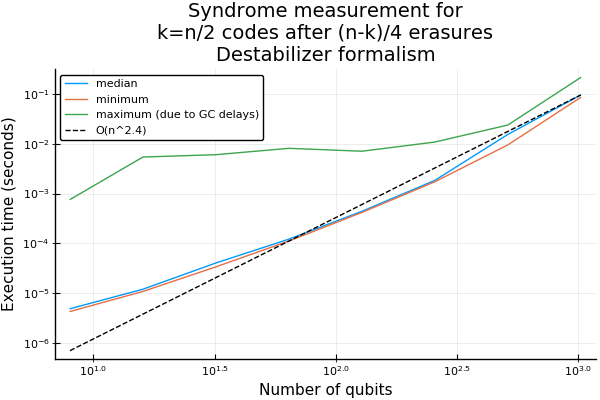

In [18]:
plotres(pows,res,"Syndrome measurement for\nk=n/2 codes after (n-k)/4 erasures\nDestabilizer formalism")

In [20]:
using Profile
using ProfileView

In [21]:
n = 1000
code, state = setup(n)
state = calculate_destabilizer(state)
@profile measure(code, state);

In [ ]:
code, state = setup(n)
state = calculate_destabilizer(state)
@benchmark measure(c, s) setup=((c,s)=(copy($code),copy($state)))